In [1]:
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import matplotlib.pyplot as plt
import sensitivity_calculator as sens

import sys
sys.path.append('/root/')
import pcl_actpol_utility_v4 as pau
#import pcl_actpol_utility_v4 as pau

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

#(env) root@DESKTOP-NP65TI5:~# python3 -m ipykernel install --user --name=env



In [2]:
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 4.66,
    "a_kSZ": 1.60,
    "a_p": 6.87,
    "beta_p": 2.08,
    "a_c": 6.10,
    "beta_c": 2.08,
    "n_CIBC": 1.20,
    "xi": 0.09,
    "a_s": 3.50,
    "a_g": 0.88,
}

In [3]:
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())

In [4]:
#freqs = np.array([100.0,150.0,280.0,350.0,850.0])
freqs = np.array([150.0,280.0,350.0,281.0,349.0,850.0,851.0])
#freqs = np.array([100.0,150.0,280.0,350.0,850.0])
ells = np.arange(2, 8000)

In [5]:
par["a_s"] * radio(
    {"nu": freqs, "beta": -0.5 + 2, "nu_0": par["nu_0"]},
    {"ell": ells, "alpha": 2, "ell_0": par["ell_0"]},
)

array([[[1.55555556e-06, 3.50000000e-06, 6.22222222e-06, ...,
         2.48702257e+01, 2.48764460e+01, 2.48826671e+01],
        [1.28361970e-05, 2.88814433e-05, 5.13447881e-05, ...,
         2.05225147e+02, 2.05276476e+02, 2.05327811e+02],
        [3.97892205e-05, 8.95257461e-05, 1.59156882e-04, ...,
         6.36150147e+02, 6.36309254e+02, 6.36468381e+02],
        ...,
        [3.91477471e-05, 8.80824309e-05, 1.56590988e-04, ...,
         6.25894268e+02, 6.26050810e+02, 6.26207372e+02],
        [1.70853115e-01, 3.84419508e-01, 6.83412458e-01, ...,
         2.73159998e+06, 2.73228318e+06, 2.73296646e+06],
        [1.73786082e-01, 3.91018685e-01, 6.95144328e-01, ...,
         2.77849227e+06, 2.77918720e+06, 2.77988221e+06]],

       [[1.28361970e-05, 2.88814433e-05, 5.13447881e-05, ...,
         2.05225147e+02, 2.05276476e+02, 2.05327811e+02],
        [1.05922256e-04, 2.38325077e-04, 4.23689026e-04, ...,
         1.69348527e+03, 1.69390883e+03, 1.69433244e+03],
        [3.28334319e-04, 

In [6]:
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

In [7]:
specs = get_fg_model(freqs, ells, par)
np.array(specs).shape

(7, 7, 7, 7998)

In [8]:
# specs = specs[:-2]
# np.array(specs).shape

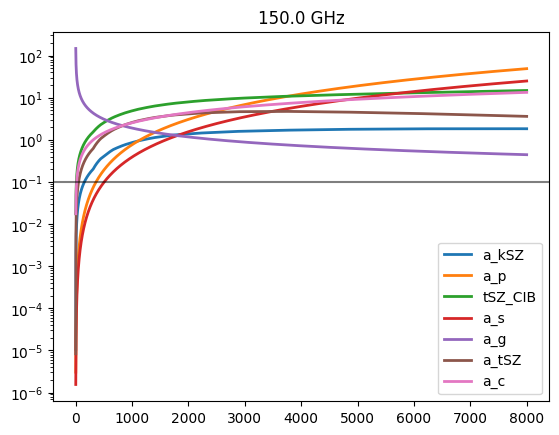

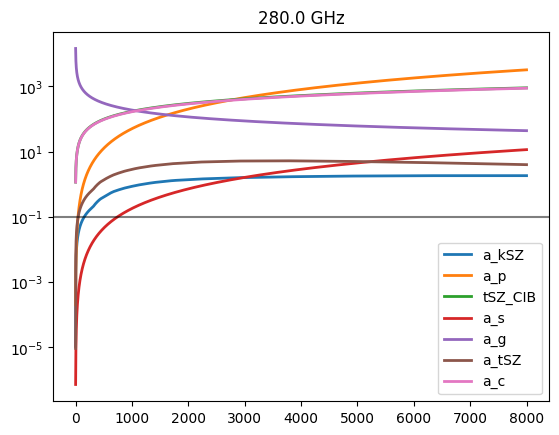

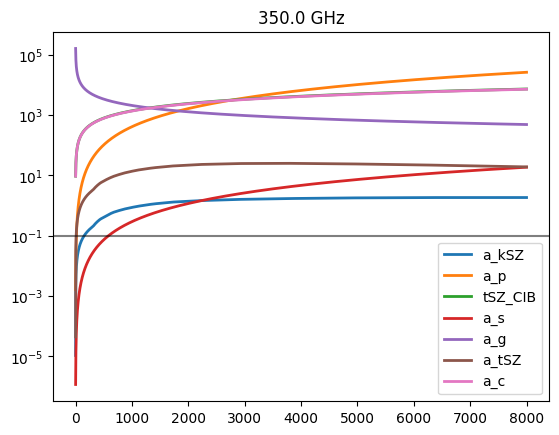

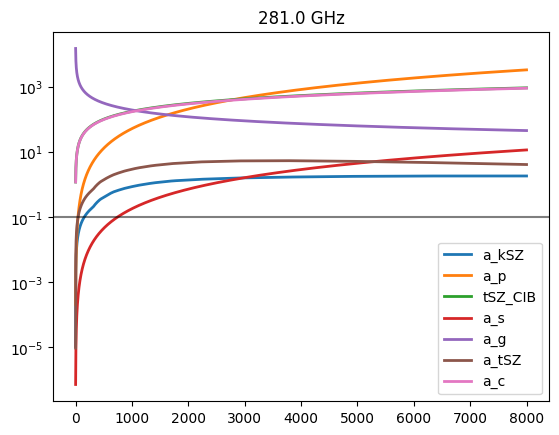

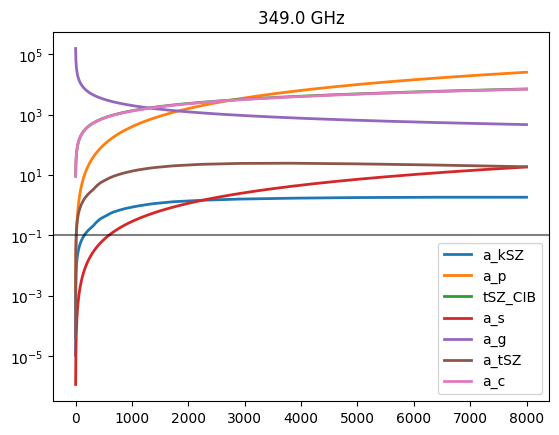

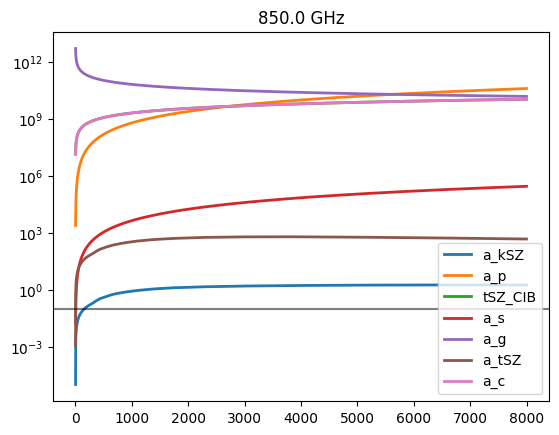

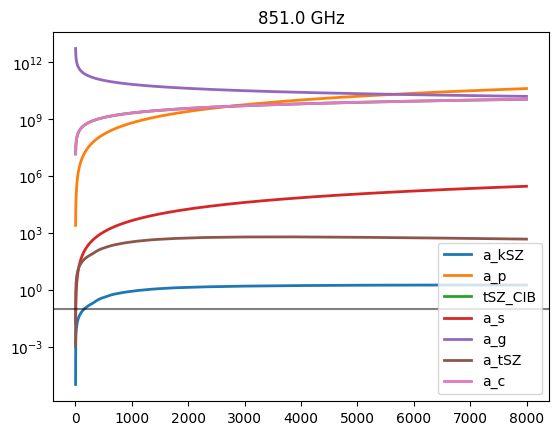

In [9]:
%matplotlib inline
lab = ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c']

col = []
for j in range(len(freqs)):
    for i in range(len(np.array(specs))):
        plt.plot(ells, specs[i][j, j], lw=2, label='%s'%lab[i])
        col.append(specs[i][j, j][3000])

    plt.legend()
    plt.yscale('log')
    plt.title('%.1f GHz'%freqs[j])
    plt.axhline(y=1e-1,alpha=0.5,color='k')
    plt.show()
    

(7, 7)


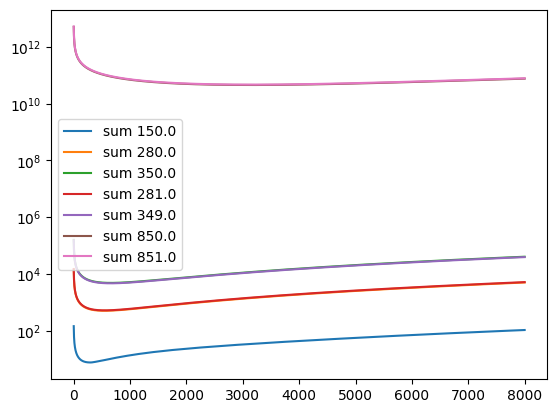

In [10]:

col = np.array(col).reshape(len(freqs),-1)
print(col.shape)

sum_sig = []
for i in range(len(freqs)):
    sum_sig.append(np.sum([s[i, i] for s in specs], axis=0))
    plt.plot(ells, np.sum([s[i, i] for s in specs], axis=0), label="sum %.1f"%freqs[i])

plt.legend()
#plt.title("%.1fx%.1f"%(freqs[i],freqs[i]))
plt.yscale("log")
plt.show()

In [11]:
import sensitivity_calculator as sens


inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=False)
print(spillEfficiency)
spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
print(spillEfficiency)
# spillEfficiency = np.array([0.8,0.5,0.7,0.95,0.5])
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
outputs = calculate(45)
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs)

[0.96784622 0.76695759 0.86552148 0.70397119 0.63296344]
[0.76390292 0.49038857 0.60958542 0.46697733 0.40693271]


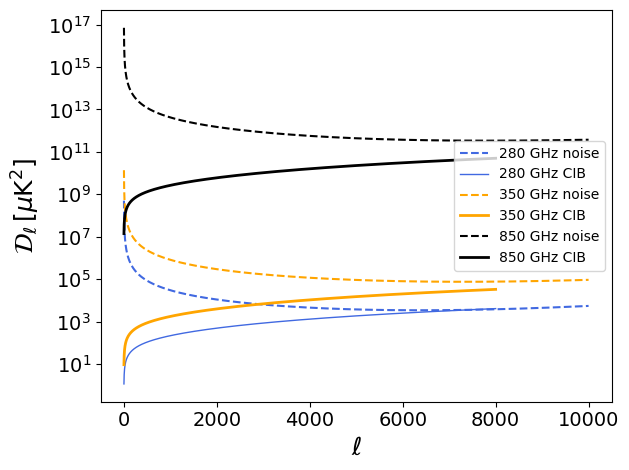

In [12]:
%matplotlib inline
cib_150 = specs[1][0,0]+specs[6][0,0]
cib_280 = specs[1][1,1]+specs[6][1,1]
cib_350 = specs[1][2,2]+specs[6][2,2]
cib_281 = specs[1][3,3]+specs[6][3,3]
cib_349 = specs[1][4,4]+specs[6][4,4]
cib_850 = specs[1][5,5]+specs[6][5,5]
cib_851 = specs[1][6,6]+specs[6][6,6]
# print(N_ell_T_full.shape)
# plt.plot(ells,cib_150, lw=2, label='150 GHz')
dl = ell*(ell+1)/(2*np.pi)
plt.plot(ell,N_ell_T_full[3]*dl,label='280 GHz noise',linestyle='--',color='RoyalBlue')
plt.plot(ells,cib_280, lw=1, label='280 GHz CIB',color='RoyalBlue')
# plt.plot(ells,cib_350, lw=1, label='350 GHz CIB',color='Orange')
plt.plot(ell,N_ell_T_full[2]*dl, label='350 GHz noise',linestyle='--',color='Orange')
plt.plot(ells,cib_350, lw=2, label='350 GHz CIB',color='Orange')
plt.plot(ell,N_ell_T_full[0]*dl, label='850 GHz noise',linestyle='--',color='Black')
plt.plot(ells,cib_850, lw=2, label='850 GHz CIB',color='Black')

plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$\mathcal{D}_\ell \, [\mu \mathrm{K}^2]$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(50,8000)
# plt.ylim(10,1e6)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_signal_noise_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  # Specify facecolor to ensure white background
plt.show()


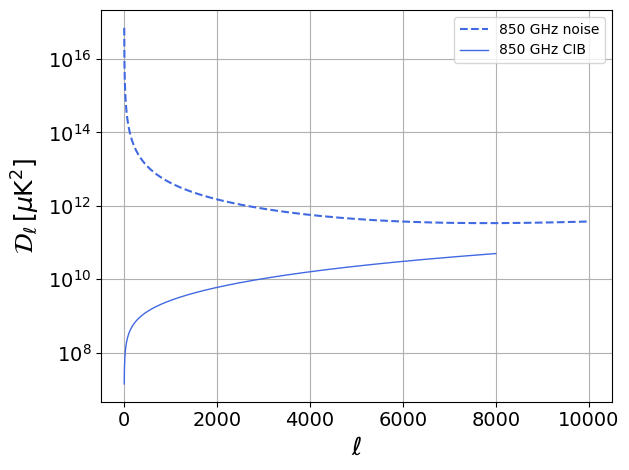

<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline
plt.plot(ell,N_ell_T_full[0]*dl,label='850 GHz noise',linestyle='--',color='RoyalBlue')
plt.plot(ells,cib_850, lw=1, label='850 GHz CIB',color='RoyalBlue')
# plt.plot(ells,cib_350, lw=1, label='350 GHz CIB',color='Red')
# # plt.plot(ells,cib_350, lw=1, label='350 GHz CIB',color='Orange')
# plt.plot(ell,N_ell_T_full[2]*dl, label='350 GHz noise',linestyle='--',color='Orange')
# plt.plot(ells,cib_350, lw=2, label='350 GHz CIB',color='Orange')
plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$\mathcal{D}_\ell \, [\mu \mathrm{K}^2]$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(50,8000)
# plt.ylim(10,1e6)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.grid()
plt.show()
plt.savefig('./cib_signal_noise_850GHz.png', bbox_inches='tight', facecolor='white',dpi=200)  # Specify facecolor to ensure white background


fsky=0.4988


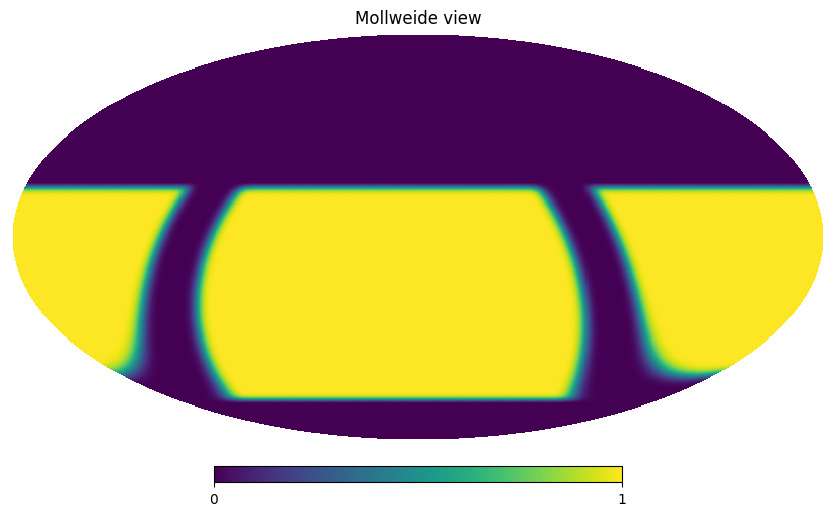

In [14]:
import healpy as hp
NSIDE = 1024
hitmap_path = "~/mask_share/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
mask_path = "~/mask_share/nside" + str(NSIDE) + "_lat_cut_b10_230619.fits"
hitm = hp.read_map(hitmap_path)
maskm = hp.read_map(mask_path)
hp.mollview(hitm*maskm)
# hp.mollview(maskm)
fsky = np.sum(hitm*maskm)/len(hitm)
fsky = get_hivon_fsky(hitm*maskm)
print('fsky=%.4f'%fsky)

In [15]:

lmax_cut = 8000
binfile = '/root/BIN_ACTPOL_50_4_SC_low_ell'
lbands = pau.read_binfile(binfile, lcut=lmax_cut)
(ell_bin, band, nbins, lmax, elxx, dxx) = pau.get_lbands_all(lbands)
g_fac = pau.get_analytic_var_cross(fsky, ell_bin, band)

In [16]:
cib_280_bin = cib_280[np.array(ell_bin-1.5,'int')]
cib_281_bin = cib_281[np.array(ell_bin-1.5,'int')]
cib_350_bin = cib_350[np.array(ell_bin-1.5,'int')]
cib_349_bin = cib_349[np.array(ell_bin-1.5,'int')]
cib_850_bin = cib_850[np.array(ell_bin-1.5,'int')]
cib_851_bin = cib_851[np.array(ell_bin-1.5,'int')]

In [17]:
nl_280_bin = (N_ell_T_full[3]*dl)[np.array(ell_bin-1.5,'int')]
nl_350_bin = (N_ell_T_full[2]*dl)[np.array(ell_bin-1.5,'int')]
nl_850_bin = (N_ell_T_full[0]*dl)[np.array(ell_bin-1.5,'int')]

In [18]:
err_280 = np.sqrt(2)*g_fac*(cib_280_bin+nl_280_bin)
err_350 = np.sqrt(2)*g_fac*(cib_350_bin+nl_350_bin)
err_850 = np.sqrt(2)*g_fac*(cib_850_bin+nl_850_bin)

In [19]:
sum_sig = np.array(sum_sig)
sig_280_bin = sum_sig[1][np.array(ell_bin-1.5,'int')]
sig_350_bin = sum_sig[2][np.array(ell_bin-1.5,'int')]
sig_850_bin = sum_sig[5][np.array(ell_bin-1.5,'int')]
tot_err_280 = np.sqrt(2)*g_fac*(sig_280_bin+nl_280_bin)
tot_err_350 = np.sqrt(2)*g_fac*(sig_350_bin+nl_350_bin)
tot_err_850 = np.sqrt(2)*g_fac*(sig_850_bin+nl_850_bin)

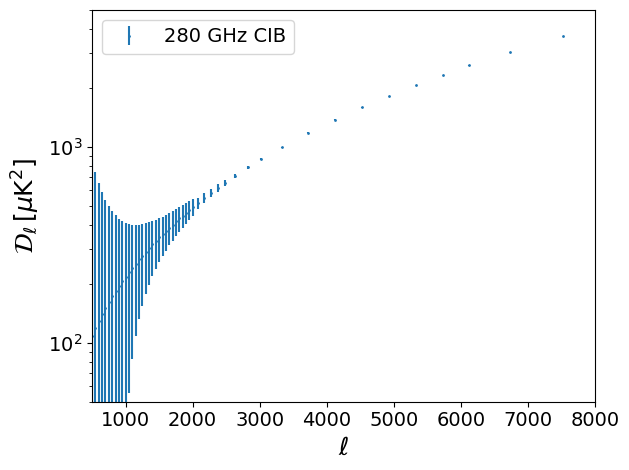

In [20]:
%matplotlib inline
plt.errorbar(ell_bin, cib_280_bin, err_280,label='280 GHz CIB',fmt='o',markersize=1)
# plt.errorbar(ell_bin+3, cib_350_bin, err_350,label='350 GHz CIB')
plt.legend(fontsize=14)
plt.yscale('log')
plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$\mathcal{D}_\ell \, [\mu \mathrm{K}^2]$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(500,8000)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.ylim(50,5e3)
plt.savefig('./cib_err_280_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  # Specify facecolor to ensure white background

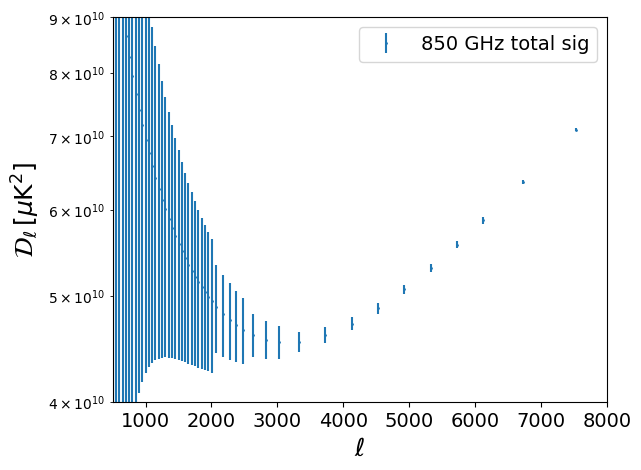

In [21]:
%matplotlib inline
plt.errorbar(ell_bin, sig_850_bin, tot_err_850,label='850 GHz total sig',fmt='o',markersize=1)
plt.legend(fontsize=14)
plt.yscale('log')
plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$\mathcal{D}_\ell \, [\mu \mathrm{K}^2]$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(500,8000)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.ylim(4e10,9e10)
plt.savefig('./sig_err_850_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  # Specify facecolor to ensure white background

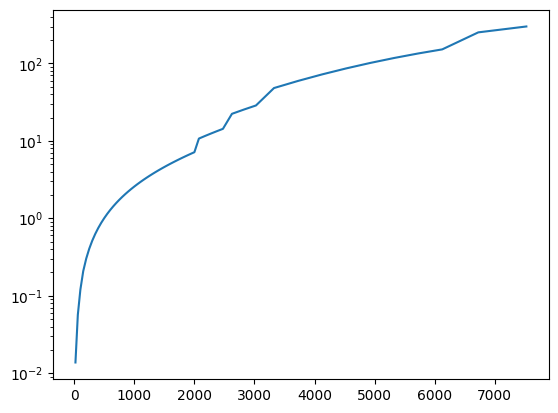

In [22]:
%matplotlib inline
plt.plot(ell_bin, sig_850_bin/tot_err_850)
plt.yscale('log')
plt.show()

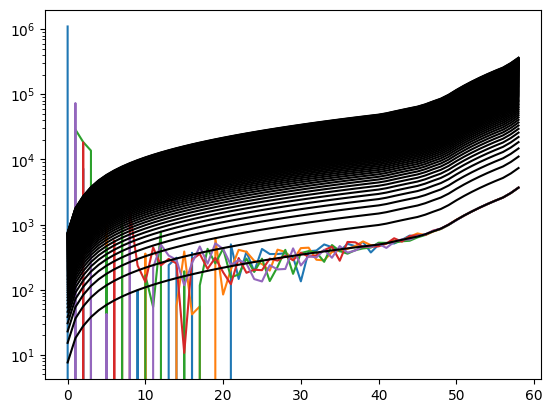

In [51]:
N = 500
cib_try = np.random.normal(cib_280_bin, err_280, size=(N,len(err_280)))

plt.plot(cib_try[0])
plt.plot(cib_try[1])
plt.plot(cib_try[2])
plt.plot(cib_try[3])
plt.plot(cib_try[4])
plt.yscale('log')

for a in range(-100,100):
    plt.plot(a*cib_280_bin, color = "black")


In [52]:
from scipy.optimize import minimize

# Define your chi-square function
def chi2_280(a, data):
    chi2 = np.sum(((data - a * cib_280_bin) / err_280) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_280, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a


In [53]:
fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))

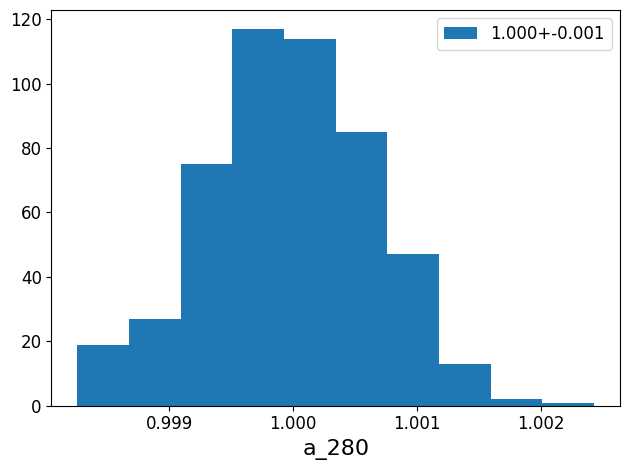

In [54]:
%matplotlib inline
fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.xlabel('a_280',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_280GHz_fit_no_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  # Specify facecolor to ensure white background

In [55]:
def chi2_281(a, data):
    chi2 = np.sum(((data - a * cib_281_bin) / err_280) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_281, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a

In [56]:
fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))

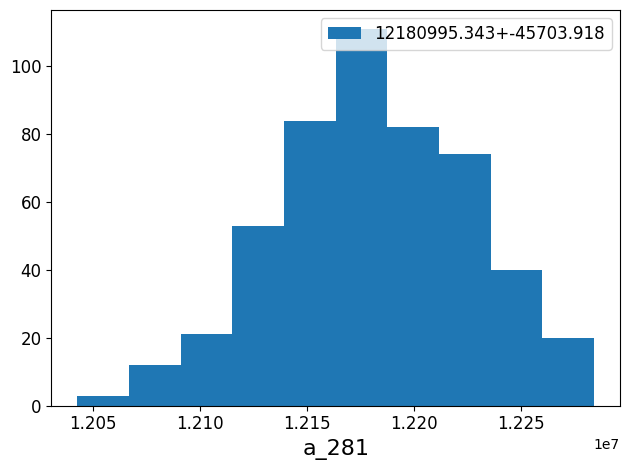

In [47]:
%matplotlib inline
fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.legend(fontsize=12)
plt.xlabel('a_281',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_280GHz_fit_1GHz_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)

In [30]:
N = 500
cib_try = np.random.normal(cib_350_bin, err_350, size=(N,len(err_350)))

In [31]:
# Define your chi-square function
def chi2_350(a, data):
    chi2 = np.sum(((data - a * cib_350_bin) / err_350) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_350, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a

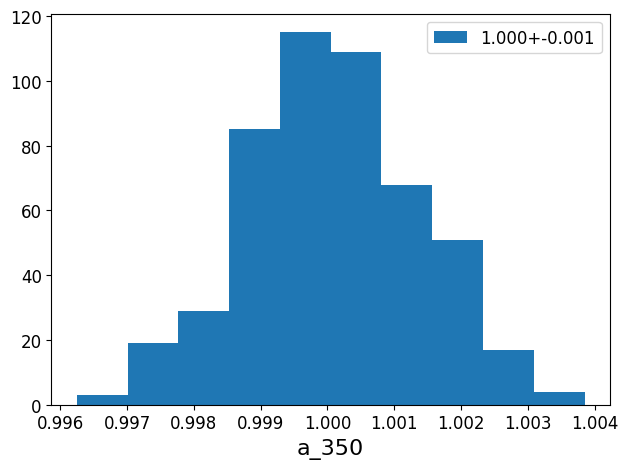

In [32]:
%matplotlib inline

fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))


fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.legend(fontsize=12)
plt.xlabel('a_350',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_350GHz_fit_no_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  

In [33]:
# Define your chi-square function
def chi2_349(a, data):
    chi2 = np.sum(((data - a * cib_349_bin) / err_350) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_349, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a

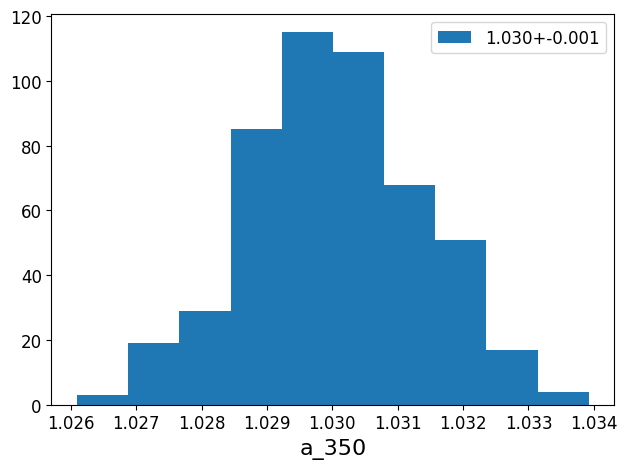

In [34]:
%matplotlib inline

fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))


fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.legend(fontsize=12)
plt.xlabel('a_350',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_350GHz_fit_1GHz_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  

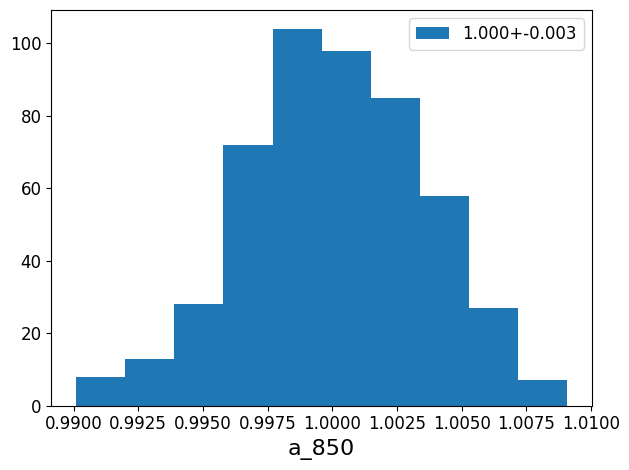

In [35]:
N = 500
cib_try = np.random.normal(cib_850_bin, err_850, size=(N,len(err_850)))

# Define your chi-square function
def chi2_850(a, data):
    chi2 = np.sum(((data - a * cib_850_bin) / err_850) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_850, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a
%matplotlib inline

fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))


fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.legend(fontsize=12)
plt.xlabel('a_850',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_850GHz_fit_no_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  
# Define your chi-square function
def chi2_851(a, data):
    chi2 = np.sum(((data - a * cib_851_bin) / err_850) ** 2)
    return chi2

# Initial guess for the parameter 'a'
initial_guess = 1.0

# Function to find the best fit for 'a'
def find_best_fit(data):
    result = minimize(chi2_851, initial_guess, args=(data,))
    optimal_a = result.x[0]
    return optimal_a

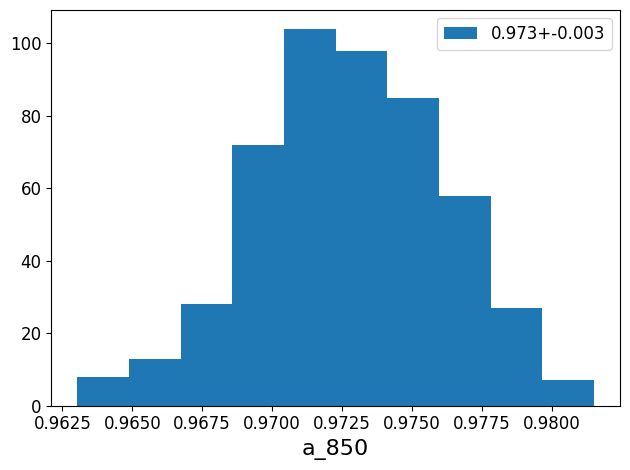

In [36]:
%matplotlib inline

fits = []
for i in range(N):    
    fits.append(find_best_fit(cib_try[i]))


fits=np.array(fits)
plt.hist(fits,label='%.3f+-%.3f'%(np.mean(fits),np.std(fits)))
plt.legend(fontsize=12)
plt.xlabel('a_850',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.savefig('./cib_850GHz_fit_1GHz_shift_240402.png', bbox_inches='tight', facecolor='white',dpi=200)  

In [37]:
h = 6.62606957e-34
c = 299792458.
kb = 1.3806488e-23

# =========== converting/blackbody functions ===========

def CMB_to_A(freq_in_GHz):
    T = 2.725
    v = freq_in_GHz*1e9
    x = h*v/(kb*T)
    return x**2*np.exp(x)/(np.exp(x)-1)**2


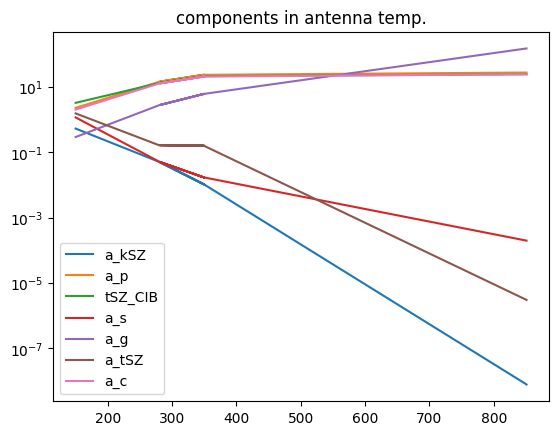

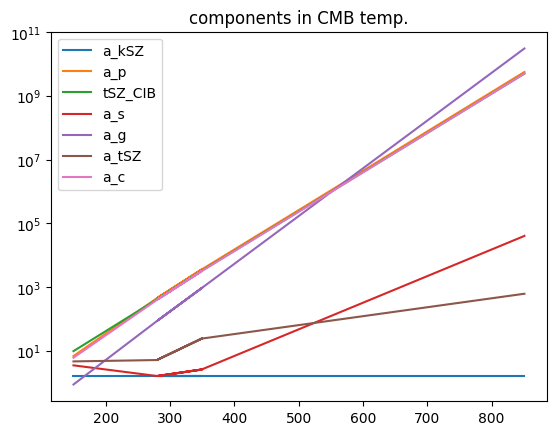

In [38]:
for i in range(len(np.array(specs))):
    plt.plot(freqs,col[:,i]*CMB_to_A(freqs)**2,label='%s'%lab[i])
    
plt.legend()
plt.yscale('log')
plt.title('components in antenna temp.')
plt.show()

for i in range(len(np.array(specs))):
    plt.plot(freqs,col[:,i],label='%s'%lab[i])
    
plt.legend()
plt.yscale('log')
plt.title('components in CMB temp.')
plt.show()